In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import random as rd

import warnings
warnings.filterwarnings('ignore')

### Data tidying

In [3]:
df = pd.read_csv("data/diamonds.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
caratPriceDict = dict()
caratAmountDict = dict()

for index, row in df.iterrows():
    if row['carat'] not in caratPriceDict.keys():
        caratPriceDict[row['carat']] = 0
    if row['carat'] not in caratAmountDict.keys():
        caratAmountDict[row['carat']] = 0

    caratPriceDict[row['carat']] += row['price']
    caratAmountDict[row['carat']] += 1

caratPriceDict = {k: v/caratAmountDict[k] for k, v in caratPriceDict.items()}
caratPriceDict = dict(sorted(caratPriceDict.items()))

carat = list(caratPriceDict.keys())
price = list(caratPriceDict.values())

caratPrice = {"carat":carat, "price":price}
dfCaratPrice = pd.DataFrame(caratPrice)
dfCaratPrice.to_csv(r'output/caratPrice.csv', index=False)

Linear function:
 
5625 x + 192.5


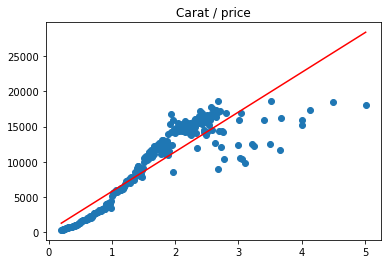

Polynomial function:
       4        3             2
514.7 x - 4797 x + 1.274e+04 x - 3957 x + 616.6


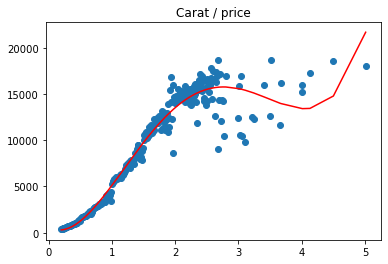

In [5]:
plt.scatter(carat, price)
z = np.polyfit(carat, price, 1)
p = np.poly1d(z)
print("Linear function:")
print(p)
trend_h = p(carat)
plt.plot(carat,trend_h, "r-")
plt.title("Carat / price")
plt.show()

plt.scatter(carat, price)
z = np.polyfit(carat, price, 4)
p = np.poly1d(z)
print("Polynomial function:")
print(p)
trend_h = p(carat)
plt.plot(carat,trend_h, "r-")
plt.title("Carat / price")
plt.show()

### Data analysis

In [6]:
df = pd.read_csv("output/caratPrice.csv")
df.head()

print(df.describe())

            carat         price
count  273.000000    273.000000
mean     1.608791   9242.669570
std      0.894875   5606.869496
min      0.200000    365.166667
25%      0.880000   3342.322581
50%      1.560000  10424.000000
75%      2.240000  14481.333333
max      5.010000  18701.000000


### Model 1 - Linear regression

Prior predictive check

In [139]:
model_1_ppc = CmdStanModel(stan_file='model_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [140]:
data_sim={'N':len(df), 'carat':df.carat}
model_1_sim = model_1_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


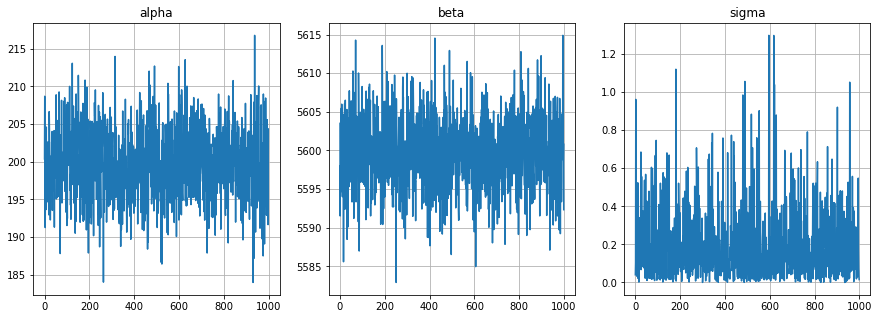

,mean,sd,hdi_3%,hdi_97%
alpha,199.69,4.84,191.52,208.98
beta,5599.82,4.84,5590.06,5608.17
sigma,0.19,0.19,0.00,0.54


In [141]:
alpha_sim = model_1_sim.stan_variable('alpha')
beta_sim = model_1_sim.stan_variable('beta')
sigma_sim = model_1_sim.stan_variable('sigma')
price_sim = model_1_sim.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(model_1_sim,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

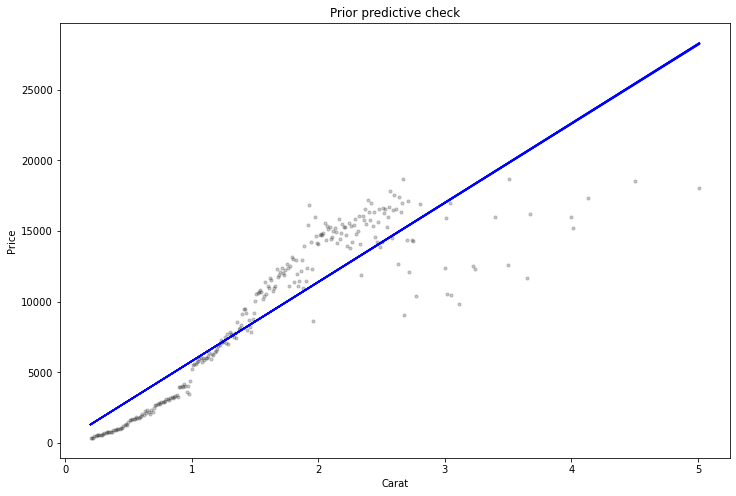

In [142]:
plt.figure(figsize=[12, 8])
for i in range(100):
    plt.plot(df.carat, alpha_sim[i] + beta_sim[i] * df.carat, alpha=0.1, color='blue')
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Prior predictive check")
plt.show()

Posterior analysis

In [143]:
model_lr = CmdStanModel(stan_file='model_lr.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_lr.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_lr.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_lr.exe


In [144]:
result_lr = model_lr.sample(data=dict(N=len(df), carat=df.carat, price=df.price))
#print(result_lr.draws_pd())

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


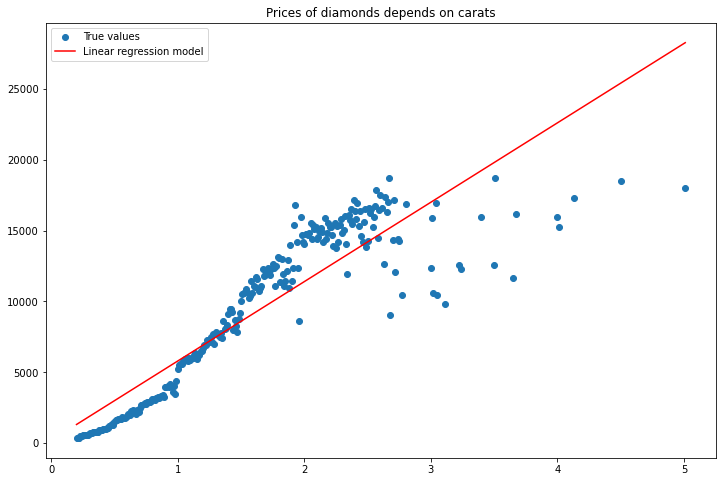

In [145]:
df_alpha = pd.DataFrame(result_lr.stan_variables()["alpha"])
df_beta = pd.DataFrame(result_lr.stan_variables()["beta"])
df_sigma = pd.DataFrame(result_lr.stan_variables()["sigma"])

alpha = df_alpha.mean().to_numpy()
beta = df_beta.mean().to_numpy()
sigma= df_sigma.mean().to_numpy()

x = df.carat.values
y = alpha + beta*x

plt.figure(figsize=[12, 8])
plt.scatter(df.carat.values, df.price.values)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Linear regression model"])
plt.show()

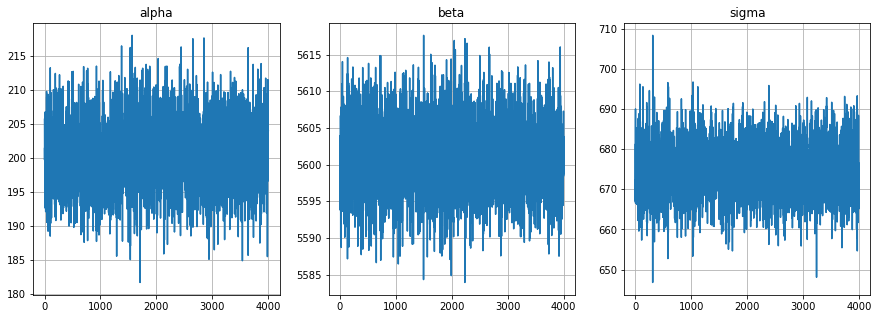

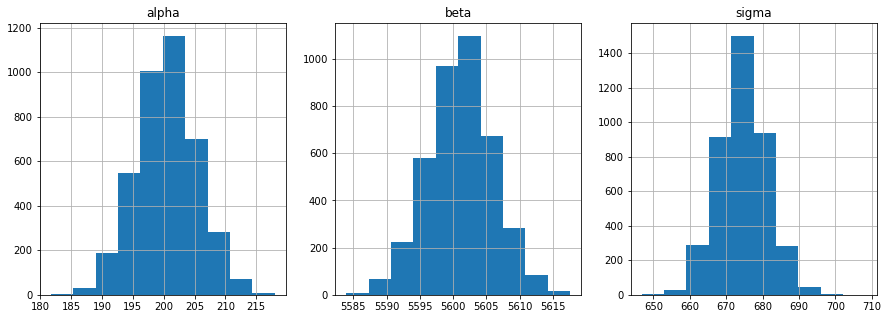

,mean,sd,hdi_3%,hdi_97%
alpha,200.49,4.91,191.30,209.66
beta,5601.14,4.89,5591.84,5610.20
sigma,674.61,6.58,662.64,687.36


In [146]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(df_beta)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(df_sigma)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(df_beta)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(df_sigma)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(result_lr,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

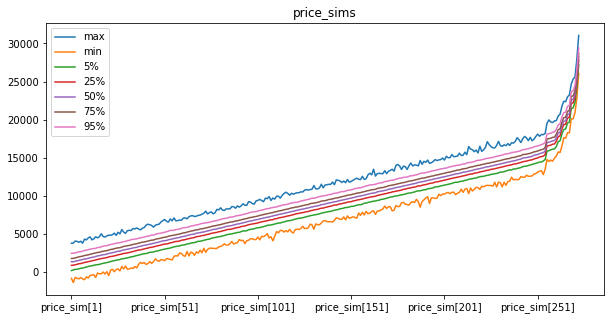

In [147]:
data = result_lr.draws_pd()
price_sims = data[data.columns[283:556]]
#print(price_sims)

quans = pd.DataFrame({'max': price_sims.max(), 'min': price_sims.min(), '5%': price_sims.quantile(0.05), '25%': price_sims.quantile(0.25), '50%': price_sims.quantile(0.5), '75%': price_sims.quantile(0.75), '95%': price_sims.quantile(0.95)})
quans.plot(figsize=(10,5))
plt.title("price_sims")
plt.show()

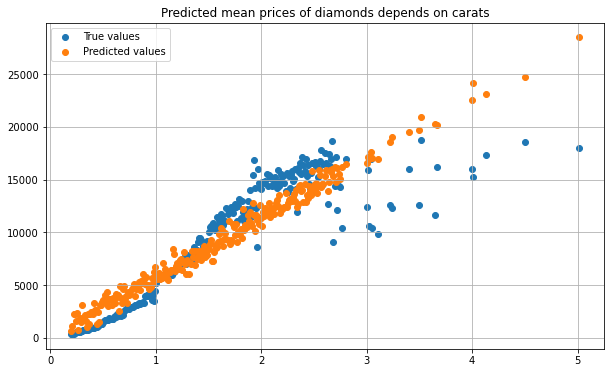

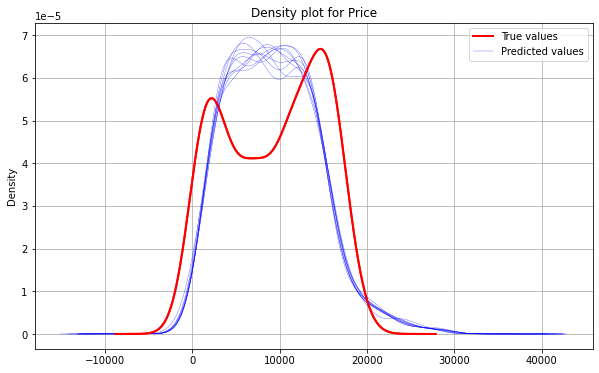

In [148]:
price_sim = result_lr.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, price_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()


df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Model 2 - Polynomial regression

Prior predictive check

In [89]:
model_2_ppc = CmdStanModel(stan_file='model_2_ppc.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_2_ppc.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_2_ppc.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_2_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Marcin/AppData/Local/Temp/tmpprcah8w8/tmppdn4wymj.hpp C:/Users/Marcin/AppData/Local/Temp/tmpprcah8w8/tmppdn4wymj.stan
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmpprcah8w8/tmppdn4wymj.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmpprcah8w8/tmppdn4wymj.stan', line 13, column 4: Declarat

In [91]:
data_sim={'N':len(df), 'carat':df.carat}
model_2_sim = model_2_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


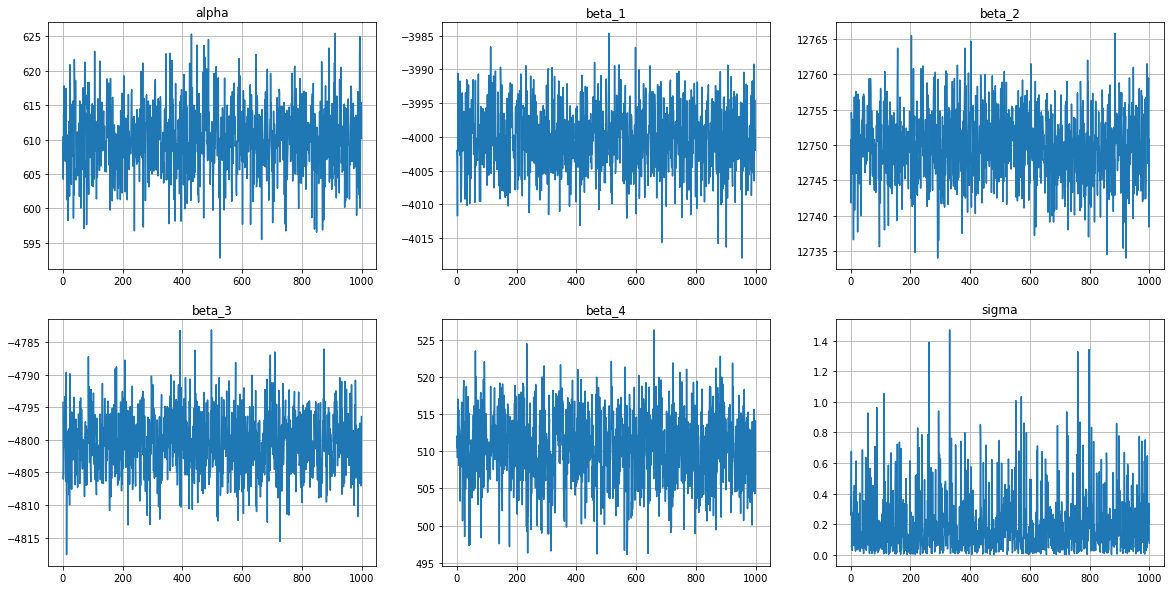

,mean,sd,hdi_3%,hdi_97%
alpha,610.08,5.06,600.90,620.35
beta_1,-4000.22,4.94,-4009.65,-3991.51
beta_2,12749.88,5.08,12740.90,12759.50
beta_3,-4800.26,4.86,-4808.79,-4791.22
beta_4,510.38,5.03,501.00,519.67
sigma,0.20,0.21,0.00,0.62


In [92]:
alpha_sim = model_2_sim.stan_variable('alpha')
beta_1_sim = model_2_sim.stan_variable('beta_1')
beta_2_sim = model_2_sim.stan_variable('beta_2')
beta_3_sim = model_2_sim.stan_variable('beta_3')
beta_4_sim = model_2_sim.stan_variable('beta_4')
sigma_sim = model_2_sim.stan_variable('sigma')
price_sim = model_1_sim.stan_variable('price')

fig, axs = plt.subplots(2,3)
fig.set_size_inches(20, 10)
axs[0][0].plot(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(beta_1_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_1')
axs[0][2].plot(beta_2_sim)
axs[0][2].grid()
axs[0][2].set_title('beta_2')
axs[1][0].plot(beta_3_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_3')
axs[1][1].plot(beta_4_sim)
axs[1][1].grid()
axs[1][1].set_title('beta_4')
axs[1][2].plot(sigma_sim)
axs[1][2].grid()
axs[1][2].set_title('sigma')
plt.show()

az.summary(model_2_sim,var_names=['alpha','beta_1','beta_2','beta_3','beta_4','sigma'],round_to=2,kind='stats')

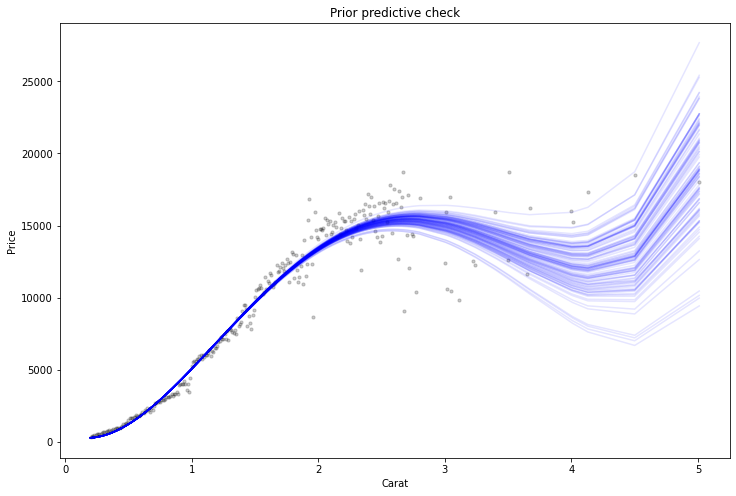

In [93]:
plt.figure(figsize=[12, 8])
for i in range(100):
    plt.plot(df.carat, alpha_sim[i] + beta_1_sim[i] * df.carat + beta_2_sim[i] * df.carat**2 + beta_3_sim[i] * df.carat**3 + beta_4_sim[i] * df.carat**4, alpha=0.1, color='blue')
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Prior predictive check")
plt.show()

Posterior analysis

In [95]:
model_pr = CmdStanModel(stan_file='model_pr.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_pr.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_pr.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_pr.exe


In [102]:
result_pr = model_pr.sample(data=dict(N=len(df), carat=df.carat, price=df.price))
#print(result_pr.draws_pd())

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


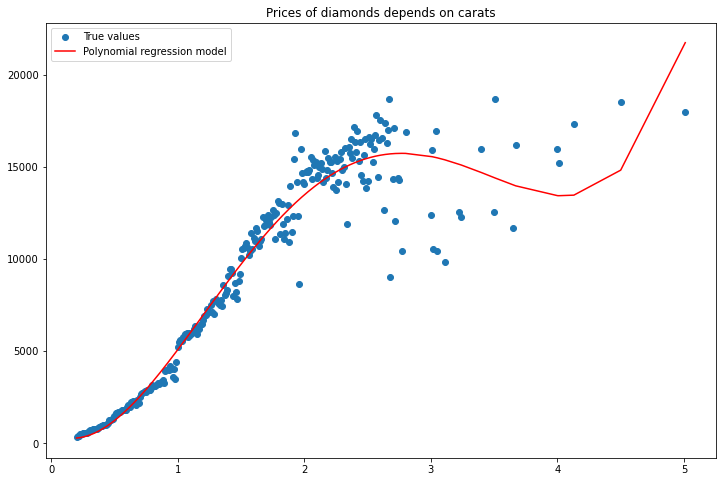

In [103]:
df_alpha = pd.DataFrame(result_pr.stan_variables()["alpha"])
df_beta_1 = pd.DataFrame(result_pr.stan_variables()["beta_1"])
df_beta_2 = pd.DataFrame(result_pr.stan_variables()["beta_2"])
df_beta_3 = pd.DataFrame(result_pr.stan_variables()["beta_3"])
df_beta_4 = pd.DataFrame(result_pr.stan_variables()["beta_4"])
df_sigma = pd.DataFrame(result_pr.stan_variables()["sigma"])

alpha = df_alpha.mean().to_numpy()
beta_1 = df_beta_1.mean().to_numpy()
beta_2 = df_beta_2.mean().to_numpy()
beta_3 = df_beta_3.mean().to_numpy()
beta_4 = df_beta_4.mean().to_numpy()

sigma= df_sigma.mean().to_numpy()

x = df.carat.values
y = alpha + beta_1*x + beta_2*(x**2) + beta_3*(x**3) + beta_4*(x**4)

plt.figure(figsize=[12, 8])
plt.scatter(df.carat.values, df.price.values)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Polynomial regression model"])
plt.show()

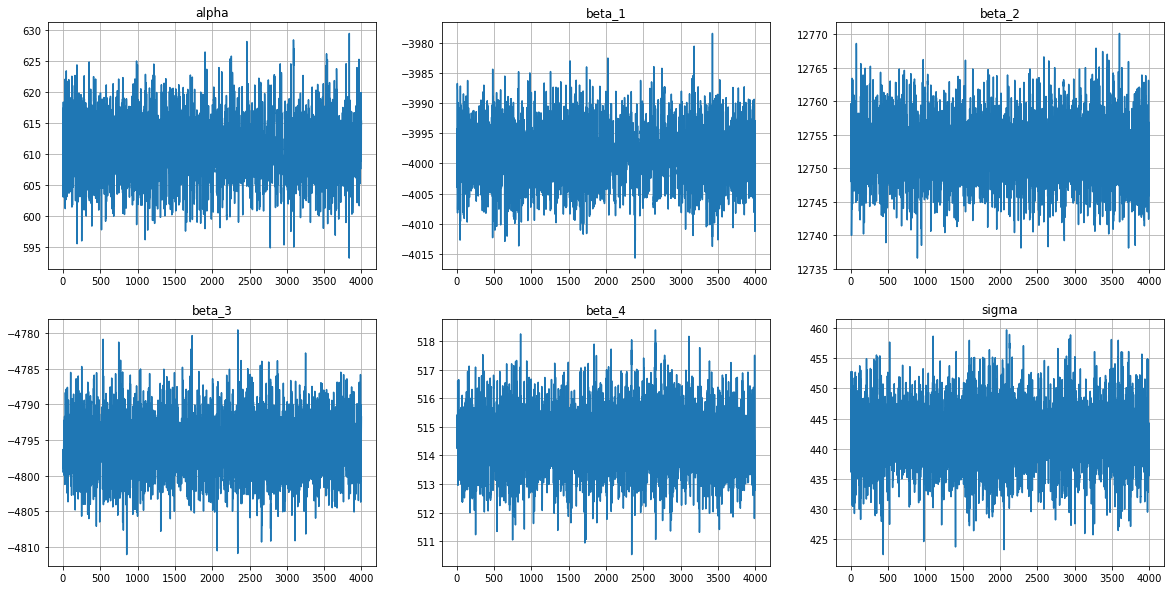

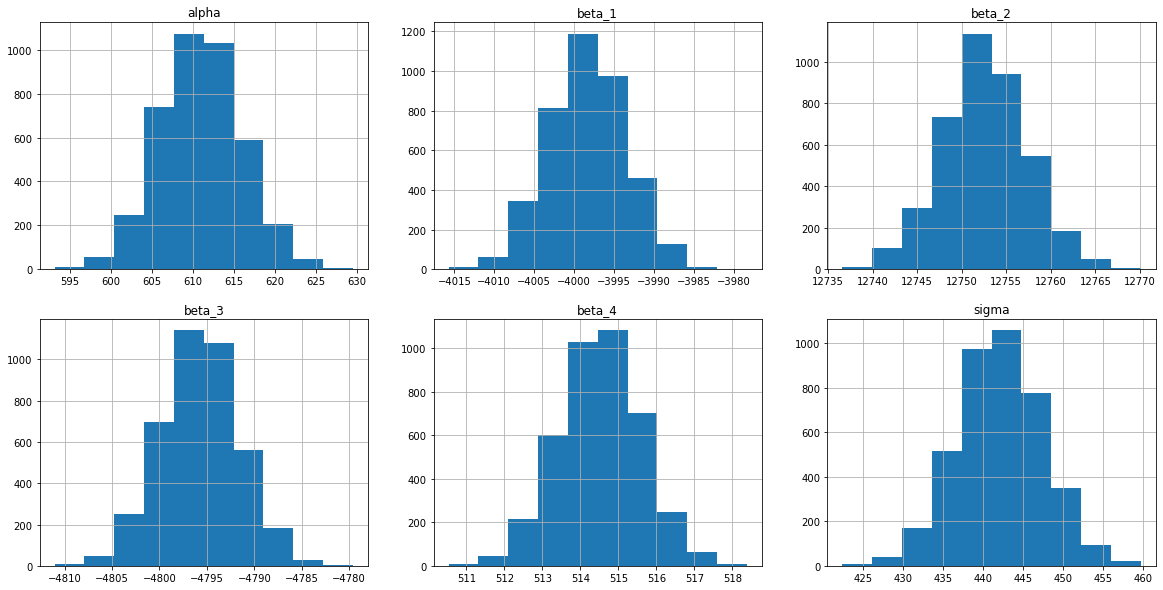

,mean,sd,hdi_3%,hdi_97%
alpha,610.08,5.06,600.90,620.35
beta_1,-4000.22,4.94,-4009.65,-3991.51
beta_2,12749.88,5.08,12740.90,12759.50
beta_3,-4800.26,4.86,-4808.79,-4791.22
beta_4,510.38,5.03,501.00,519.67
sigma,0.20,0.21,0.00,0.62


In [105]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(20, 10)
axs[0][0].plot(df_alpha)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(df_beta_1)
axs[0][1].grid()
axs[0][1].set_title('beta_1')
axs[0][2].plot(df_beta_2)
axs[0][2].grid()
axs[0][2].set_title('beta_2')
axs[1][0].plot(df_beta_3)
axs[1][0].grid()
axs[1][0].set_title('beta_3')
axs[1][1].plot(df_beta_4)
axs[1][1].grid()
axs[1][1].set_title('beta_4')
axs[1][2].plot(df_sigma)
axs[1][2].grid()
axs[1][2].set_title('sigma')
plt.show()

fig, axs = plt.subplots(2,3)
fig.set_size_inches(20, 10)
axs[0][0].hist(df_alpha)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].hist(df_beta_1)
axs[0][1].grid()
axs[0][1].set_title('beta_1')
axs[0][2].hist(df_beta_2)
axs[0][2].grid()
axs[0][2].set_title('beta_2')
axs[1][0].hist(df_beta_3)
axs[1][0].grid()
axs[1][0].set_title('beta_3')
axs[1][1].hist(df_beta_4)
axs[1][1].grid()
axs[1][1].set_title('beta_4')
axs[1][2].hist(df_sigma)
axs[1][2].grid()
axs[1][2].set_title('sigma')
plt.show()

az.summary(model_2_sim,var_names=['alpha','beta_1','beta_2','beta_3','beta_4','sigma'],round_to=2,kind='stats')

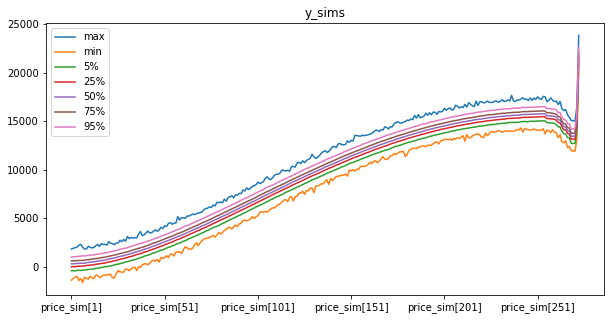

In [115]:
data = result_pr.draws_pd()
price_sims = data[data.columns[286:559]]
#print(price_sims)

quans = pd.DataFrame({'max': price_sims.max(), 'min': price_sims.min(), '5%': price_sims.quantile(0.05), '25%': price_sims.quantile(0.25), '50%': price_sims.quantile(0.5), '75%': price_sims.quantile(0.75), '95%': price_sims.quantile(0.95)})
quans.plot(figsize=(10,5))
plt.title("y_sims")
plt.show()

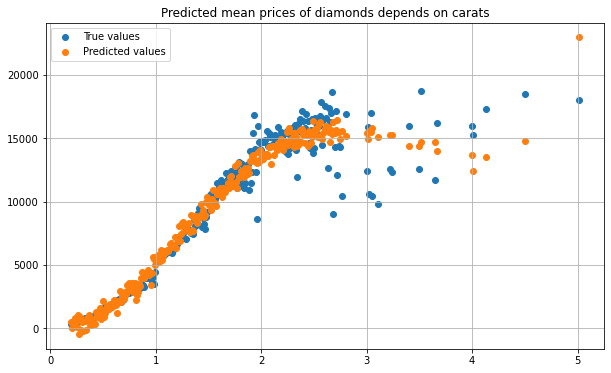

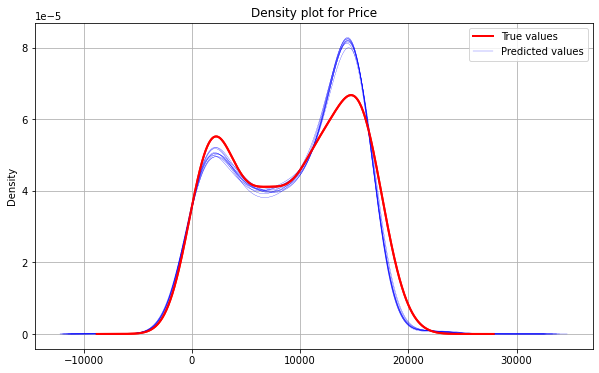

In [116]:
price_sim = result_pr.stan_variable('price_sim')

plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, price_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()


df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Model 3 - Gaussian process

Prior optimization

In [125]:
model_gp_opt = CmdStanModel(stan_file='model_gp_opt.stan')
data = dict(N = len(df), carat = df.carat, price = df.price)
result_gp_opt = model_gp_opt.optimize(data=data, algorithm='Newton')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [137]:
result = result_gp_opt.optimized_params_pd

alpha = float(result['alpha'])
rho = float(result['rho'])
sigma = float(result['sigma'])

print("Optimization result:")
print(f"alpha = {alpha}")
print(f"rho = {rho}")
print(f"sigma = {sigma}")

Optimization result:
alpha = 130.0
rho = 1.0
sigma = 100.0


Posterior analysis

In [131]:
model_gp = CmdStanModel(stan_file='model_gp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [133]:
idx = range(1, len(df.price)+1)
data = dict(N = len(df), carat = df.carat, price = df.price, idx = idx, rho=rho, alpha=alpha, sigma=sigma)
result_gp = model_gp.sample(data=data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


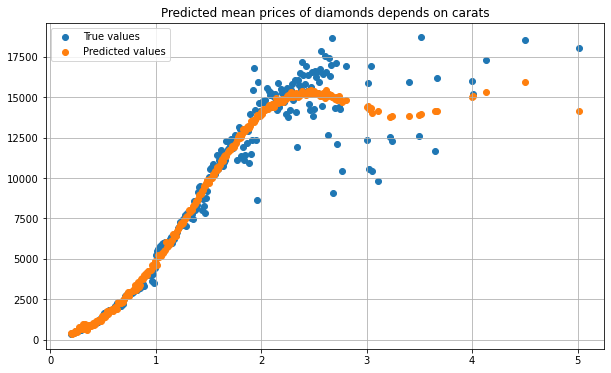

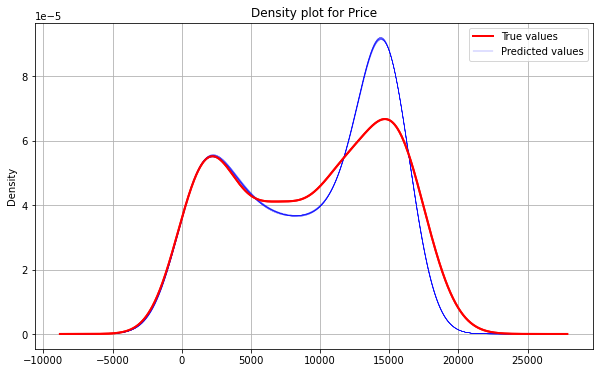

In [136]:
data = result_gp.draws_pd()
price_sims = data[data.columns[826:]]
price_sim = result_gp.stan_variable('price_sim')

plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, price_sim[0])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Comparison of models



           rank           loo        p_loo         d_loo    weight  \
model_pr_     0  -2529.956273    15.066954      0.000000  0.667129   
model_lr_     1  -3253.954762    21.050077    723.998489  0.114866   
model_gp_     2 -21684.282452  1032.959315  19154.326179  0.218005   

                    se          dse  warning loo_scale  
model_pr_    67.052076     0.000000    False       log  
model_lr_    59.847464    86.468417    False       log  
model_gp_  3366.985023  3324.920579     True       log  


<AxesSubplot:xlabel='Log'>

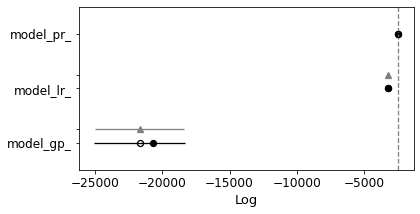

In [279]:
data = dict(linear_regression = result_lr, polynomial_regression = result_pr, gaussian_process = result_gp)
comp_loo = az.compare(data, ic = "loo")
print('\n')
print(comp_loo)
az.plot_compare(comp_loo)



           rank          waic       p_waic        d_waic    weight  \
model_pr_     0  -2529.889398    15.000078      0.000000  0.667121   
model_lr_     1  -3253.913326    21.008641    724.023928  0.114846   
model_gp_     2 -22489.971140  1838.648003  19960.081742  0.218033   

                    se          dse  warning waic_scale  
model_pr_    67.041097     0.000000     True        log  
model_lr_    59.843701    86.457324     True        log  
model_gp_  3562.774525  3522.434408     True        log  


<AxesSubplot:xlabel='Log'>

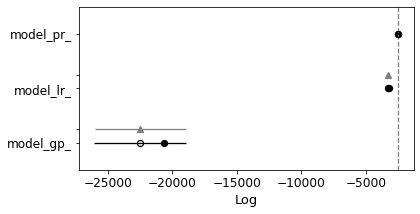

In [280]:
comp_waic = az.compare(data, ic = "waic")
print('\n')
print(comp_waic)
az.plot_compare(comp_waic)